<a href="https://colab.research.google.com/github/AkulaTejdeep/2203A52133_DAUP-PROJECT/blob/main/3DAUP_TextPRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('/content/emails.csv')

print(df.head())
print(df.columns)


                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1
Index(['text', 'spam'], dtype='object')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1: Loss=0.3710, Accuracy=0.8136
Epoch 2: Loss=0.2582, Accuracy=0.9016
Epoch 3: Loss=0.1996, Accuracy=0.9160
Epoch 4: Loss=0.1462, Accuracy=0.9446
Epoch 5: Loss=0.1453, Accuracy=0.9430
Epoch 6: Loss=0.1193, Accuracy=0.9524
Epoch 7: Loss=0.0931, Accuracy=0.9622
Epoch 8: Loss=0.0769, Accuracy=0.9670
Epoch 9: Loss=0.0624, Accuracy=0.9736
Epoch 10: Loss=0.0584, Accuracy=0.9790


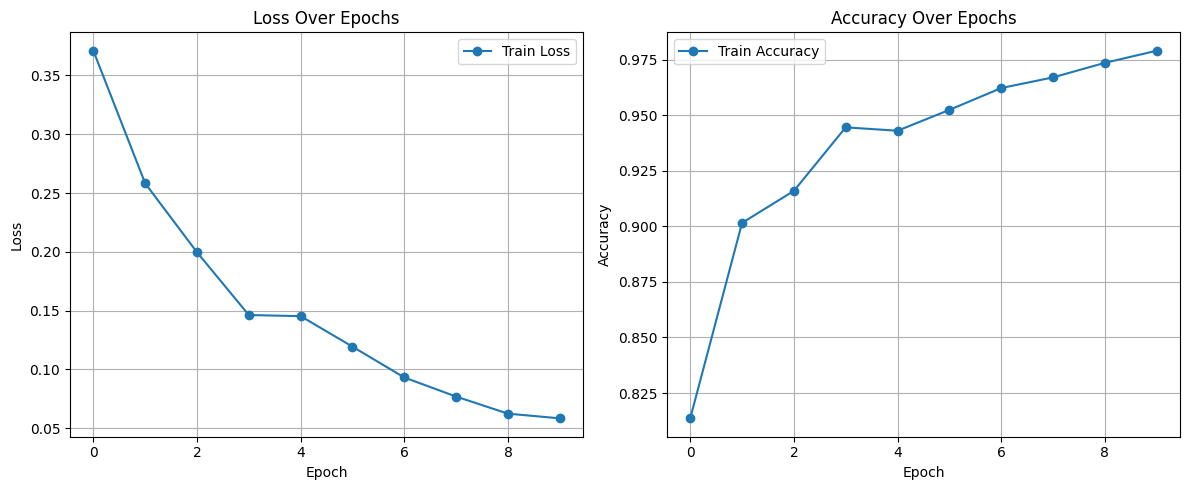

In [ ]:

import pandas as pd
import re
import nltk
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

nltk.download('punkt')

df = pd.read_csv('/content/emails.csv')

def preprocess(text):
    text = re.sub(r'\W+', ' ', text.lower())
    return word_tokenize(text)

df['tokens'] = df['text'].apply(preprocess)
df['label'] = df['spam'].astype(int)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['tokens'], df['label'], test_size=0.2, random_state=42
)

w2v_model = Word2Vec(sentences=train_texts, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = w2v_model.wv

embedding_dim = 100
max_len = 50

def vectorize(tokens):
    vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    if len(vectors) < max_len:
        vectors += [np.zeros(embedding_dim)] * (max_len - len(vectors))
    else:
        vectors = vectors[:max_len]
    return np.array(vectors)

class EmailDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [vectorize(text) for text in texts]
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.float32), torch.tensor(self.labels[idx])

train_dataset = EmailDataset(train_texts, train_labels)
test_dataset = EmailDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return self.sigmoid(out).squeeze()

model = LSTMClassifier(input_dim=embedding_dim, hidden_dim=128)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    total_loss, correct = 0, 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = (outputs > 0.5).int()
        correct += (predictions == labels).sum().item()

    acc = correct / len(train_dataset)
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Accuracy={acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
